# =====================================================
#  SENTIMENT ANALYSIS - CNN MODEL
# =====================================================


#  Imports & Setup

In [29]:

# ------------------------------
# 1. Imports & Setup
# ------------------------------
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    f1_score, precision_score, recall_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve)

from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from collections import Counter
import itertools

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K


import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING logs
warnings.filterwarnings('ignore')  # Suppress Python warnings


In [30]:

# ------------------------------
# 2. Reproducibility
# ------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



TensorFlow version: 2.18.0
Num GPUs Available: 1


In [31]:
# ------------------------------
# 3. Load Dataset
# ------------------------------
file_path = r"/kaggle/input/bersih-cleaned-text-sentimentlabeled-updated/bersih_cleaned_text_Sentimentlabeled_updated.csv"
df = pd.read_csv(file_path)

print("Dataset loaded:", df.shape)
print(df['inset_sentiment'].value_counts(), "\n")
print(df.head())

Dataset loaded: (12458, 2)
inset_sentiment
negatif    4707
positif    4707
netral     3044
Name: count, dtype: int64 

                                          clean_text inset_sentiment
0  cuma jadi komoditas politik enginer malah di p...         negatif
1  pepetah tahun ini vaksin hilang mobil dan moto...         negatif
2   kalo mobil pertama ya jgn langsung mobil listrik         positif
3  iya tau kan pemerintah kita suka ga konsisten ...         negatif
4  harapannya dengan pasokan listrik ini hasil pr...         positif


# Exploratory Data Analysis

In [32]:
df['inset_sentiment'].value_counts()

inset_sentiment
negatif    4707
positif    4707
netral     3044
Name: count, dtype: int64

In [33]:
# ------------------------------
# a. Basic Overview
# ------------------------------
print("Shape of DataFrame:", df.shape)
print("\nColumn names:", df.columns.tolist())

Shape of DataFrame: (12458, 2)

Column names: ['clean_text', 'inset_sentiment']


In [34]:

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 clean_text         0
inset_sentiment    0
dtype: int64


In [35]:

# Check unique sentiment classes
print("\nUnique sentiments:", df['inset_sentiment'].unique())
print("Class distribution:\n", df['inset_sentiment'].value_counts())



Unique sentiments: ['negatif' 'positif' 'netral']
Class distribution:
 inset_sentiment
negatif    4707
positif    4707
netral     3044
Name: count, dtype: int64


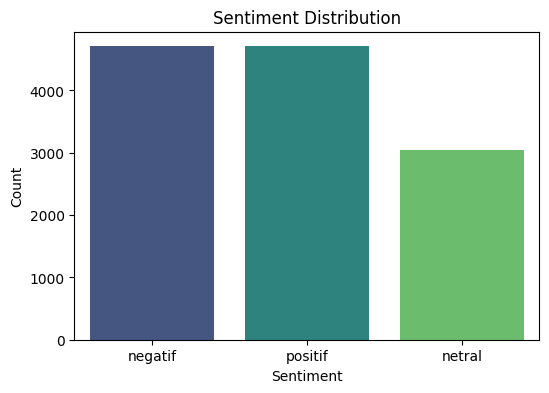

In [36]:
# ------------------------------
# b. Label Distribution
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='inset_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

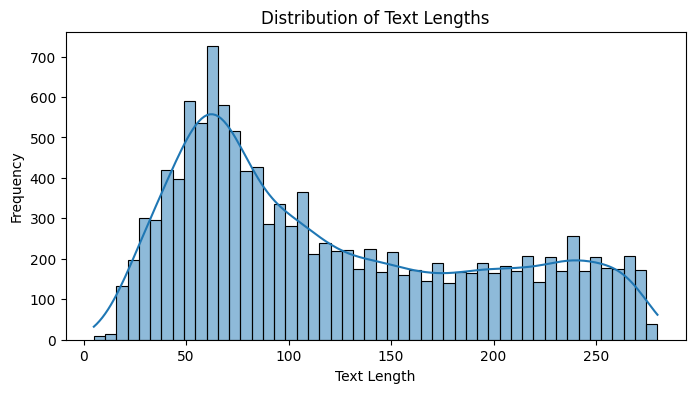


Average text length by sentiment:
inset_sentiment
negatif    141.640748
netral     129.891261
positif     96.508179
Name: text_length, dtype: float64


In [37]:
# ------------------------------
# c. Text Length Analysis
# ------------------------------
df['text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

print("\nAverage text length by sentiment:")
print(df.groupby('inset_sentiment')['text_length'].mean())

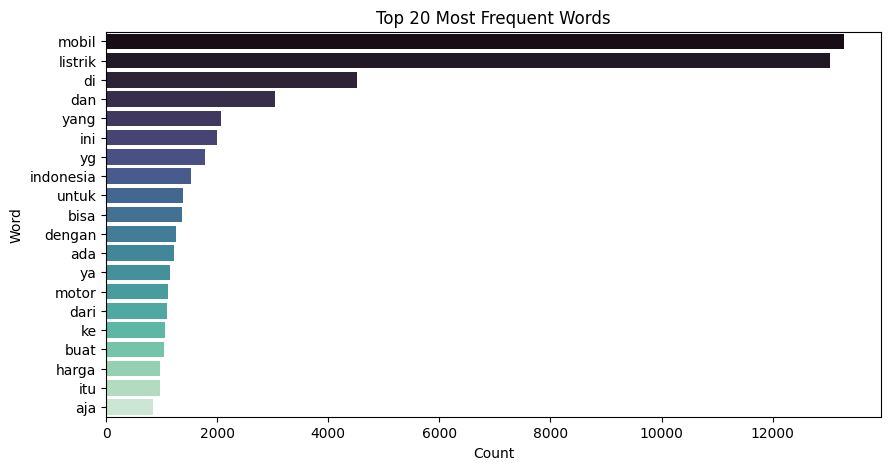

In [38]:
# ------------------------------
# d. Most Frequent Words (Simple)
# ------------------------------
from collections import Counter
import re

def get_top_n_words(corpus, n=20):
    words = [word for text in corpus for word in re.findall(r'\w+', text.lower())]
    return Counter(words).most_common(n)

top_words = get_top_n_words(df['clean_text'], 20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Word', data=top_words_df, palette='mako')
plt.title('Top 20 Most Frequent Words')
plt.show()


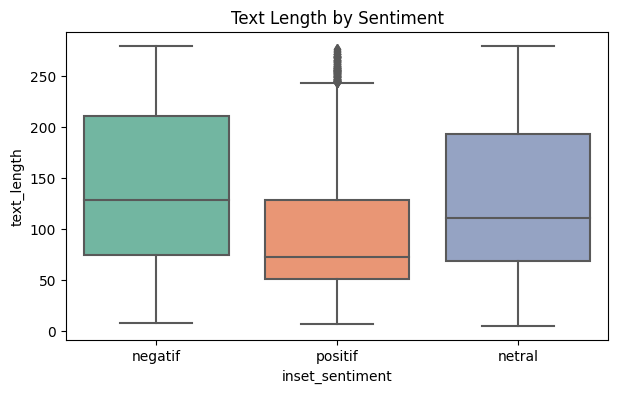

In [39]:
# ------------------------------
# e. Sentiment vs. Text Length Boxplot
# ------------------------------
plt.figure(figsize=(7,4))
sns.boxplot(x='inset_sentiment', y='text_length', data=df, palette='Set2')
plt.title('Text Length by Sentiment')
plt.show()


# Label Encoding

In [40]:
# ------------------------------
# 4. Label Encoding
# ------------------------------
le = LabelEncoder()
df['label'] = le.fit_transform(df['inset_sentiment'])

In [41]:
df.head()

,clean_text,inset_sentiment,text_length,label
0,cuma jadi komoditas politik enginer malah di p...,negatif,108,0
1,pepetah tahun ini vaksin hilang mobil dan moto...,negatif,65,0
2,kalo mobil pertama ya jgn langsung mobil listrik,positif,48,2
3,iya tau kan pemerintah kita suka ga konsisten ...,negatif,225,0
4,harapannya dengan pasokan listrik ini hasil pr...,positif,142,2


In [42]:
df['label'].value_counts()

label
0    4707
2    4707
1    3044
Name: count, dtype: int64

# Text Tokenization & Padding

In [43]:
# ------------------------------
# 5. Text Tokenization & Padding
# ------------------------------
MAX_VOCAB = 20000 #------------------------------------------------------------------------------------------------------------------------
MAX_LEN = 100 #------------------------------------------------------------------------------------------------------------------------

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')
y = df['label'].values


# Inspect & Balance Neutral Samples (if imbalance exists)

In [44]:
# ------------------------------
# 6. Inspect & Balance Neutral Samples (if imbalance exists)
# ------------------------------
neutral_label = list(le.classes_).index('neutral') if 'neutral' in le.classes_ else None
if neutral_label is not None:
    counts = pd.Series(y).value_counts()
    print("Label Distribution Before Balancing:\n", counts, "\n")

    min_count = counts.min()
    df_balanced = pd.concat([
        df[df['label'] == i].sample(min_count, random_state=SEED)
        for i in counts.index
    ])
    df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

    X = tokenizer.texts_to_sequences(df_balanced['clean_text'])
    X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')
    y = df_balanced['label'].values

    print("Label Distribution After Balancing:\n", pd.Series(y).value_counts(), "\n")

# Data Split (Train/Val/Test = 70/15/15)

In [45]:
# ------------------------------
# 7. Data Split (Train/Val/Test = 70/15/15)
# ------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=SEED)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}\n")

Train: (8725, 100), Val: (1864, 100), Test: (1869, 100)



# Class Weights

In [46]:
# ------------------------------
# 8. Class Weights
# ------------------------------
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights, "\n")

Class Weights: {0: 0.8821150540895764, 1: 1.3647739715313625, 2: 0.8821150540895764} 



# Build CNN Model

In [47]:
# ------------------------------
# 9. Build CNN Model
# ------------------------------
def build_cnn_model():
    model = models.Sequential([
        layers.Embedding(input_dim=MAX_VOCAB, output_dim=256), #input_length=MAX_LEN),     #-----------------------------
        layers.Conv1D(256, 3, activation='relu', padding='same'), #-----------------------------128--------------------------------------4-----------------------------------------------------
        layers.GlobalMaxPooling1D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    optimizer = optimizers.Adam(learning_rate=5e-4)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Train Model 

In [48]:
# ------------------------------
# 10. Train Model (with Early Stopping)
# ------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model = build_cnn_model()
history = model.fit(
    X_train, to_categorical(y_train),
    validation_data=(X_val, to_categorical(y_val)),
    epochs=3,
    batch_size=64,  #------------------------------------------------------------------------------------------------------------------------
    class_weight=class_weights,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4103 - loss: 1.0976 - val_accuracy: 0.5633 - val_loss: 0.9839 - learning_rate: 5.0000e-04
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5888 - loss: 0.9538 - val_accuracy: 0.6518 - val_loss: 0.7956 - learning_rate: 5.0000e-04
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7128 - loss: 0.7158 - val_accuracy: 0.7087 - val_loss: 0.7025 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 3.


# Final Evaluation on Test Set

In [49]:
# ------------------------------
# 11. Final Evaluation on Test Set
# ------------------------------
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))


Classification Report:
               precision    recall  f1-score   support

     negatif       0.82      0.74      0.78       706
      netral       0.42      0.55      0.48       457
     positif       0.77      0.70      0.73       706

    accuracy                           0.68      1869
   macro avg       0.67      0.66      0.66      1869
weighted avg       0.70      0.68      0.69      1869

Accuracy: 0.6773675762439807
Macro F1: 0.6628286225092274
Precision: 0.6712799010855557
Recall: 0.6623037298305862


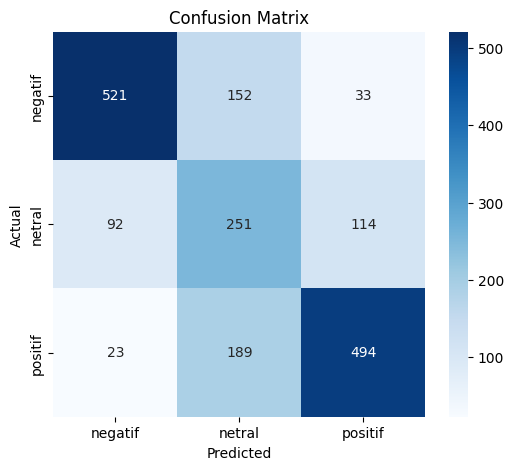

In [50]:
# ------------------------------
# 12. Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


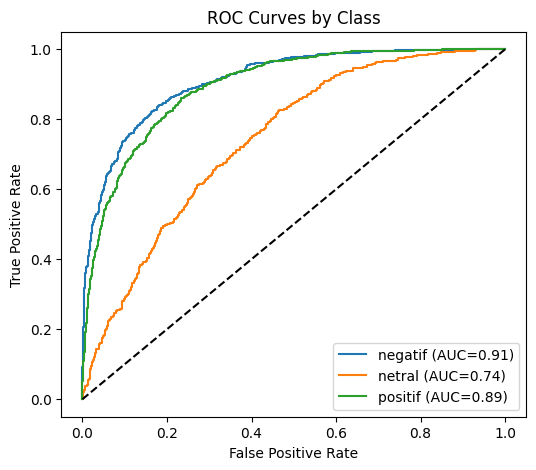

In [51]:
# ------------------------------
# 13. ROC & AUC
# ------------------------------
y_test_bin = to_categorical(y_test, num_classes=3)
y_pred_prob = model.predict(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,5))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend()
plt.show()


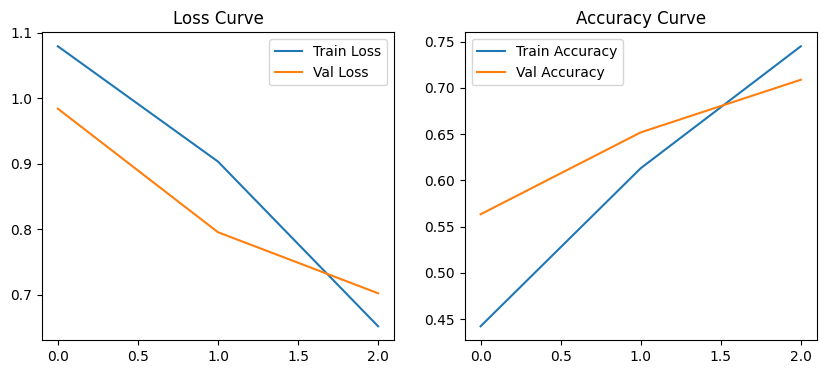

In [52]:
# ------------------------------
# 14. Training Curves
# ------------------------------
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
